<a href="https://colab.research.google.com/github/RayanovRishat/Uni-AI/blob/main/%D0%9F%D1%80%D0%B5%D0%B4%D0%BE%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B0_%D0%A1%D1%82%D0%B0%D1%82_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D1%81%D0%BE%D0%B7%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B4%D0%B0%D1%82%D0%B0%D1%84%D1%80%D0%B5%D0%B9%D0%BC%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Импорт библиотек**

In [1]:
# Импортируем библиотеки
import pandas as pd
import re
import os

**1. Загрузка и подготовка данных**

In [2]:
# Подключаем Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Указываем путь к файлу
file_path = '/content/drive/MyDrive/Colab Notebooks/СТАЖИРОВКА ООО "ГИПЕР"/reviews.xlsx'

# Проверяем, существует ли файл
if not os.path.exists(file_path):
    raise FileNotFoundError(f"Файл не найден по пути: {file_path}")

# Загружаем данные из Excel
try:
    df = pd.read_excel(file_path, engine='openpyxl')
    print("✅ Файл успешно загружен")
except Exception as e:
    raise RuntimeError(f"Ошибка при загрузке файла: {e}")

# Переименовываем столбцы для удобства (если требуется)
try:
    df.columns = ['Оценка', 'Текст_отзыва', 'Плюсы', 'Минусы', 'Дата_создания',
                  'Название_продукта', 'Артикул_продавца', 'Продавец', 'Бренд', 'Заголовок_отзыва']
    print("✅ Столбцы переименованы")
except Exception as e:
    print(f"⚠️ Не удалось переименовать столбцы: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Файл успешно загружен
✅ Столбцы переименованы


**2. Предобработка данных**

In [3]:
# Очистка текстовых данных
def clean_text(text):
    if isinstance(text, str):
        return re.sub(r'[^\w\s]', '', text.strip())
    return ''

# Применяем очистку к столбцу "Текст_отзыва"
df['Текст_отзыва'] = df['Текст_отзыва'].apply(clean_text)

# Обработка пропущенных значений
df.fillna({'Текст_отзыва': 'нет_данных', 'Оценка': 0}, inplace=True)

# Преобразование даты
df['Дата_создания'] = pd.to_datetime(df['Дата_создания'], errors='coerce')

# Добавление длины отзыва
df['Длина_отзыва'] = df['Текст_отзыва'].str.len()

# Стандартизация числовых признаков
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df['Длина_отзыва_scaled'] = scaler.fit_transform(df[['Длина_отзыва']])

# Векторизация текста
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)
X_text = vectorizer.fit_transform(df['Текст_отзыва'])

# Вывод первых строк
print("📊 Первые строки датафрейма:")
print(df.head())

📊 Первые строки датафрейма:
   Оценка                                       Текст_отзыва  \
0       2                                                      
1       1                                                      
2       1  После 3х месяцев эксплуатации потекла вода пом...   
3       1                                   Не советую брать   
4       1                                                      

                     Плюсы                                             Минусы  \
0  Обычная,только фирма ок                             Включатели не надежные   
1                      NaN                                                NaN   
2                      NaN  потекла вода помимо резервуара с кофе, вода на...   
3                   Ничего  Колонка не подключается вообще, находит , идёт...   
4                      NaN                              Прислали другой товар   

              Дата_создания  \
0 2025-03-14 09:40:33+00:00   
1 2025-03-14 07:17:50+00:00   
2 2025-

**3. Статистический анализ данных**

<ipython-input-4-16798c5afcae>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Оценка', data=df, palette='viridis')


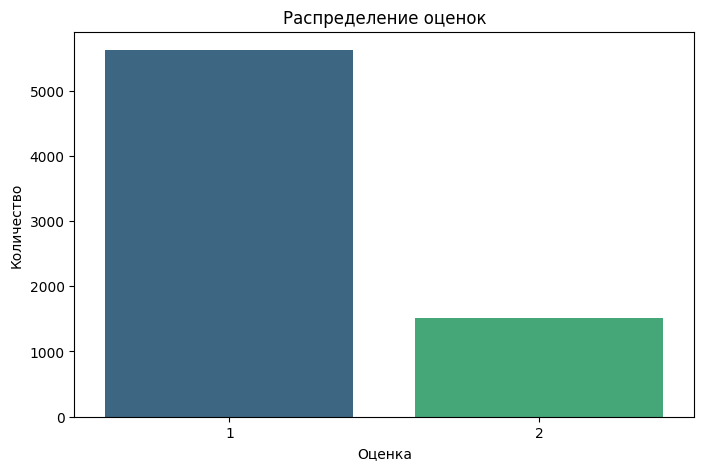

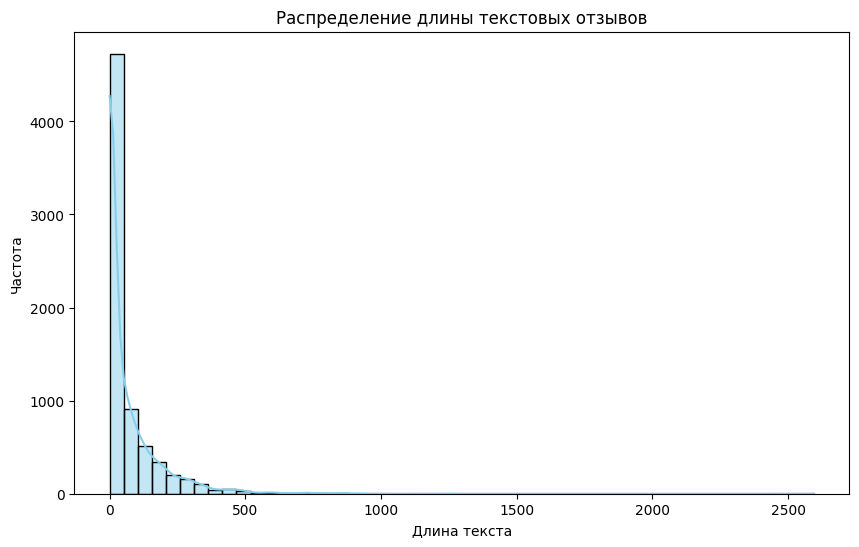

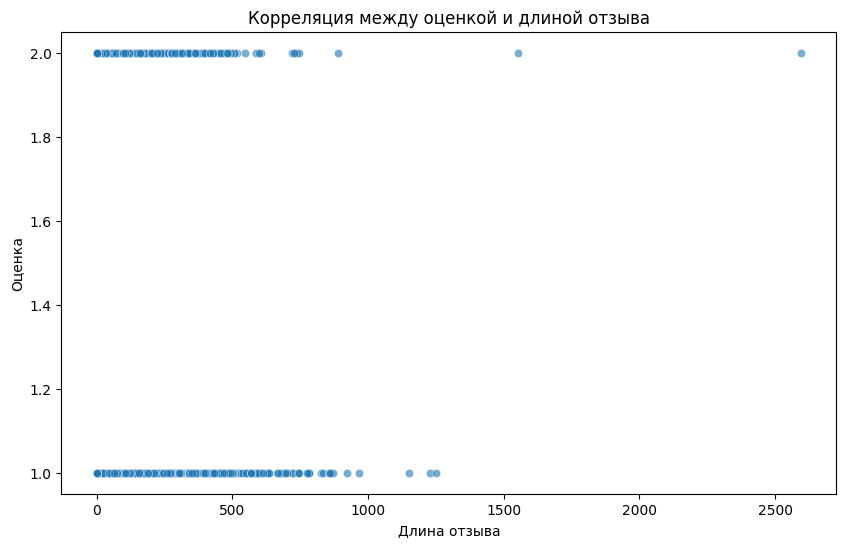

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Распределение оценок
plt.figure(figsize=(8, 5))
sns.countplot(x='Оценка', data=df, palette='viridis')
plt.title('Распределение оценок')
plt.xlabel('Оценка')
plt.ylabel('Количество')
plt.show()

# Длина отзывов
plt.figure(figsize=(10, 6))
sns.histplot(df['Длина_отзыва'], bins=50, kde=True, color='skyblue')
plt.title('Распределение длины текстовых отзывов')
plt.xlabel('Длина текста')
plt.ylabel('Частота')
plt.show()

# Корреляция между оценкой и длиной отзыва
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Длина_отзыва', y='Оценка', data=df, alpha=0.6)
plt.title('Корреляция между оценкой и длиной отзыва')
plt.xlabel('Длина отзыва')
plt.ylabel('Оценка')
plt.show()

**4. Кластеризация данных**

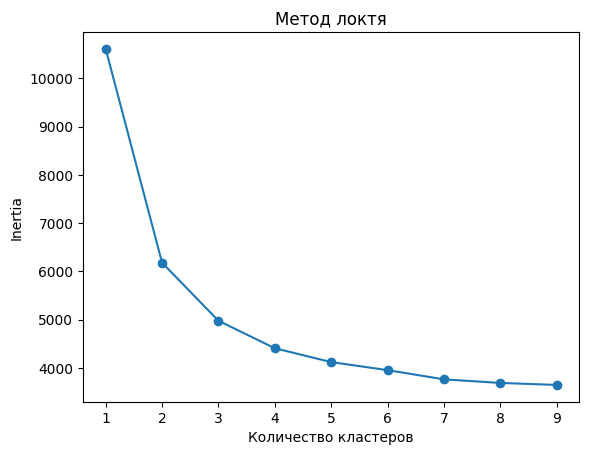

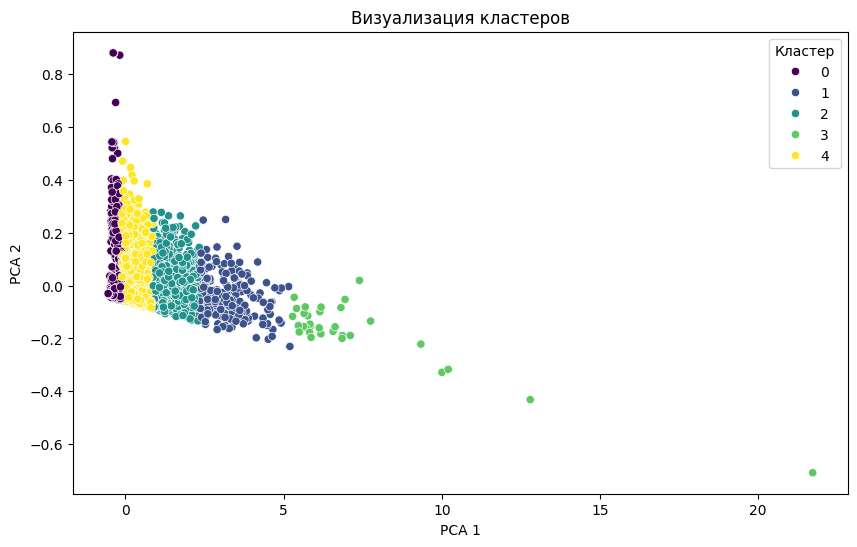

In [5]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Объединение признаков
from scipy.sparse import hstack
X_combined = hstack([X_text, df[['Длина_отзыва_scaled']].values])

# Метод локтя для выбора количества кластеров
inertias = []
K_range = range(1, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_combined)
    inertias.append(kmeans.inertia_)

# Визуализация метода локтя
plt.plot(K_range, inertias, marker='o')
plt.title('Метод локтя')
plt.xlabel('Количество кластеров')
plt.ylabel('Inertia')
plt.show()

# Выбор оптимального числа кластеров (например, 5)
kmeans = KMeans(n_clusters=5, random_state=42)
df['Кластер'] = kmeans.fit_predict(X_combined)

# Визуализация кластеров
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_combined.toarray())

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Кластер'], palette='viridis')
plt.title('Визуализация кластеров')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Кластер')
plt.show()

**5. Использование LLM для анализа данных**

In [6]:
from transformers import pipeline

# Загрузка модели для анализа тональности
try:
    classifier = pipeline('sentiment-analysis', model='blanchefort/rubert-base-cased-sentiment')
    print("✅ Модель BERT загружена")
except Exception as e:
    print(f"⚠️ Ошибка загрузки модели: {e}")
    exit()

# Функция анализа тональности
def analyze_sentiment(text):
    try:
        result = classifier(text)[0]
        return result['label']
    except:
        return 'неопределено'

# Применение LLM к текстовым данным
df['Тональность'] = df['Текст_отзыва'].apply(analyze_sentiment)

# Вывод результатов
print("📊 Результаты анализа тональности:")
print(df[['Текст_отзыва', 'Тональность']].head(10))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/943 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/499 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


✅ Модель BERT загружена
📊 Результаты анализа тональности:
                                        Текст_отзыва Тональность
0                                                        NEUTRAL
1                                                        NEUTRAL
2  После 3х месяцев эксплуатации потекла вода пом...     NEUTRAL
3                                   Не советую брать     NEUTRAL
4                                                        NEUTRAL
5                                                        NEUTRAL
6                                                        NEUTRAL
7           Просьба вернуть деньги за негодный товар    NEGATIVE
8                            Подошва вся  покарябана    NEGATIVE
9  Ребята если хотите испортить настроение себе и...    NEGATIVE


**6. Классификация отзывов по заданным категориям**

In [7]:
# Словарь ключевых слов для категорий
category_keywords = {
    "Отзыв не относится к товару": ["доставка", "упаковка", "возврат", "деньги", "получил"],
    "Отзыв оставили конкуренты": ["не советую", "лучше брать", "ненадежный", "не покупайте"],
    "Спам": ["http", "реклама", "сайт", "заработать", "купить здесь"],
    "Нецензурная лексика": ["брак", "говно", "мразь", "не работает"],
    "Отзыв с политическим контекстом": ["страна", "власть", "коррупция", "политика"]
}

# Функция классификации
def classify_review(text):
    text_lower = text.lower()
    for category, keywords in category_keywords.items():
        for word in keywords:
            if re.search(r'\b' + re.escape(word) + r'\b', text_lower):
                return category
    return "Другое"

# Применение функции
df['Категория'] = df['Текст_отзыва'].astype(str).apply(classify_review)

# Статистика по категориям
print("📊 Статистика по категориям:")
print(df['Категория'].value_counts())

# Вывод первых строк
print("\n📊 Примеры классификации:")
print(df[['Текст_отзыва', 'Категория']].head(10))

📊 Статистика по категориям:
Категория
Другое                             6208
Отзыв не относится к товару         651
Нецензурная лексика                 182
Отзыв оставили конкуренты            90
Спам                                  3
Отзыв с политическим контекстом       2
Name: count, dtype: int64

📊 Примеры классификации:
                                        Текст_отзыва  \
0                                                      
1                                                      
2  После 3х месяцев эксплуатации потекла вода пом...   
3                                   Не советую брать   
4                                                      
5                                                      
6                                                      
7           Просьба вернуть деньги за негодный товар   
8                            Подошва вся  покарябана   
9  Ребята если хотите испортить настроение себе и...   

                     Категория  
0                   

**7. Визуализация и выводы**

<ipython-input-8-3a9235dd6133>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Категория', data=df, order=df['Категория'].value_counts().index, palette='coolwarm')


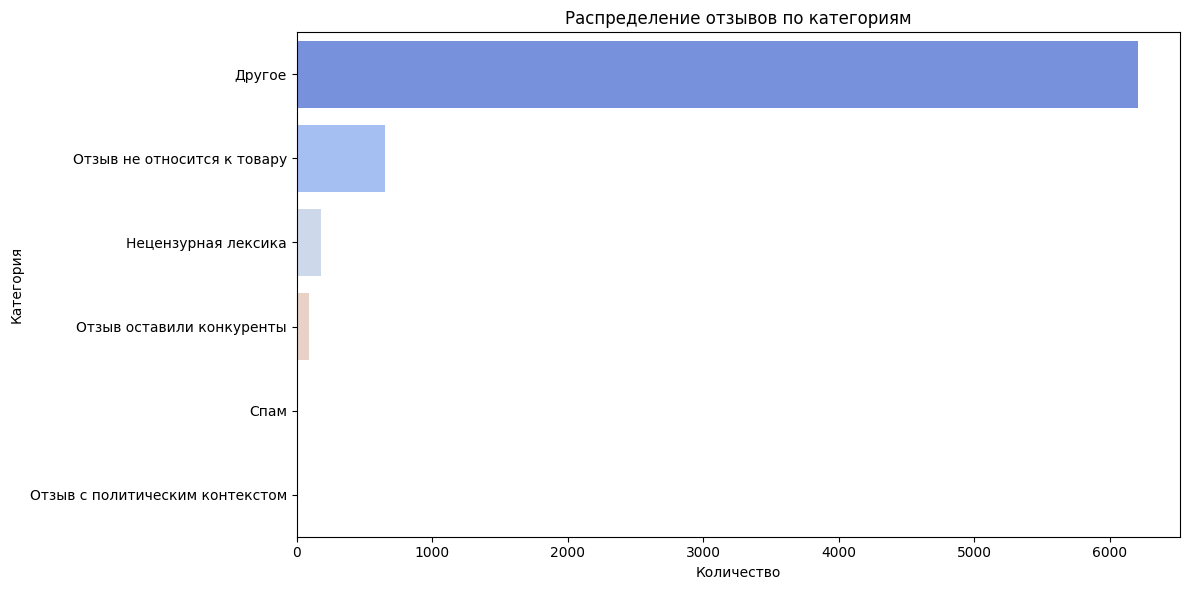


📊 Статистика по кластерам и категориям:
Категория  Другое  Нецензурная лексика  Отзыв не относится к товару  \
Кластер                                                               
0          4552.0                 48.0                         76.0   
1           102.0                 12.0                         76.0   
2           405.0                 48.0                        216.0   
3             9.0                  2.0                         20.0   
4          1140.0                 72.0                        263.0   

Категория  Отзыв оставили конкуренты  Отзыв с политическим контекстом  Спам  
Кластер                                                                      
0                               13.0                              0.0   0.0  
1                               12.0                              0.0   1.0  
2                               29.0                              0.0   1.0  
3                                0.0                              0.0  

In [8]:
# Визуализация распределения категорий
plt.figure(figsize=(12, 6))
sns.countplot(y='Категория', data=df, order=df['Категория'].value_counts().index, palette='coolwarm')
plt.title('Распределение отзывов по категориям')
plt.xlabel('Количество')
plt.ylabel('Категория')
plt.tight_layout()
plt.show()

# Вывод статистики по кластерам и категориям
print("\n📊 Статистика по кластерам и категориям:")
print(df.groupby('Кластер')['Категория'].value_counts().unstack().fillna(0))

**8. Сохранение результатов**

In [9]:
# Сохранение обработанного датафрейма
output_path = 'processed_reviews.csv'
df.to_csv(output_path, index=False)
print(f"\n✅ Данные сохранены в файл: {output_path}")


✅ Данные сохранены в файл: processed_reviews.csv


**9. Полный датасет после обработки**

In [10]:
print("\n📊 Итоговая структура датафрейма:")
print(df.head())


📊 Итоговая структура датафрейма:
   Оценка                                       Текст_отзыва  \
0       2                                                      
1       1                                                      
2       1  После 3х месяцев эксплуатации потекла вода пом...   
3       1                                   Не советую брать   
4       1                                                      

                     Плюсы                                             Минусы  \
0  Обычная,только фирма ок                             Включатели не надежные   
1                      NaN                                                NaN   
2                      NaN  потекла вода помимо резервуара с кофе, вода на...   
3                   Ничего  Колонка не подключается вообще, находит , идёт...   
4                      NaN                              Прислали другой товар   

              Дата_создания  \
0 2025-03-14 09:40:33+00:00   
1 2025-03-14 07:17:50+00:00   
2